In [15]:
import torch
from mlp import make_dataset, CharacterLevelMLP, Linear, BatchNormalization1D, Tanh
import matplotlib.pyplot as plt
from torch.optim import Adam
from pathlib import Path
from torch.nn.functional import cross_entropy
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.functional import F
%matplotlib inline

In [16]:
names_file = Path("./names.txt")
context_window = 3
X , Y, itos = make_dataset(names_file, context_window=context_window)

In [17]:
train_X, eval_X, train_Y, eval_Y = train_test_split(X,Y,test_size=0.2)
val_X, test_X, val_Y, test_Y = train_test_split(eval_X,eval_Y,test_size=0.5)

In [18]:
def compare_grad(s: str, dt, t:Tensor):
    exact_match = torch.all(dt == t.grad).item()
    approximate_match = torch.allclose(dt, t.grad)
    max_difference = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact {str(exact_match):5s} | approximate {str(approximate_match):5s} | max_diff {str(max_difference)}")
    

In [19]:
n_embedding = 10
n_hidden = 64
vocab_size = 27
block_size = context_window

In [20]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embedding), generator=g)
W1 = torch.randn((n_embedding*block_size, n_hidden), generator=g)*(5/3)/((n_embedding*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g)*0.1
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.1
b2 = torch.randn(vocab_size, generator=g)*0.1

bngain = torch.randn((1,n_hidden))*0.1 + 1.0
bnbias = torch.randn((1,n_hidden))*0.1

parameters = [C,W1,b1,W2,b2,bngain,bnbias]
print("Total parameters",sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

Total parameters 4137


In [21]:
batch_size = 32
n = batch_size
ix = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
Xb, Yb = train_X[ix], train_Y[ix]

### Forward pass

In [22]:
# Embed the characters into vectors
emb = C[Xb]

# Concatenate the vectors
embcat = emb.view(emb.shape[0],-1)

# Linear layer 1
hprebn = embcat @ W1 + b1

# Batch norm 1 stage
bnmean1 = (1/n)*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmean1
bndiff2 = bndiff**2
bnvar = (1/(n-1))*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar+1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non linearity activation
h = torch.tanh(hpreact)

# Linear layer 2
logits = h @ W2 + b2

# Cross Entropy Loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()

# Calculate loss
loss = -logprobs[range(n), Yb].mean()

for p in parameters:
    p.grad = None
    
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmean1, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3002, grad_fn=<NegBackward0>)

### Step by step Backward pass

In [23]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n
compare_grad("dlogprobs",dlogprobs,logprobs)
dprobs = (1/probs)*dlogprobs
compare_grad("dprobs",dprobs,probs)
dcounts_sum_inv = (counts*dprobs).sum(1, keepdim=True)
compare_grad("dcounts_sum_inv",dcounts_sum_inv,counts_sum_inv)
dcounts_sum = (-(1/counts_sum**2) * dcounts_sum_inv)
compare_grad("dcounts_sum",dcounts_sum,counts_sum)
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
compare_grad("dcounts",dcounts,counts)
dnorms_logits = norm_logits.exp() * dcounts
compare_grad("dnorms_logits",dnorms_logits,norm_logits)
dlogit_maxes = -dnorms_logits.clone().sum(1, keepdim=True)
compare_grad("dlogit_maxes",dlogit_maxes,logit_maxes)
dlogits = dnorms_logits.clone()
# Karpathys optimized solution
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
# # My simple dump solution
# dlogits_extra = torch.zeros_like(logits)
# for i, max_ix in enumerate(logits.max(1).indices):
#     dlogits_extra[i, max_ix] = dlogit_maxes[i]
# or
# dlogits_extra[torch.arange(logits.size(0)), max_indices] = dlogit_maxes.squeeze()
# dlogits += dlogits_extra
compare_grad("dlogits",dlogits,logits)
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.clone().sum(0)
compare_grad("dh",dh,h)
compare_grad("dW2",dW2,W2)
compare_grad("db2",db2,b2)
dhpreact = (1 - h**2) * dh
compare_grad("dhpreact",dhpreact,hpreact)
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = (dhpreact * bngain)
dbnbias = dhpreact.sum(0, keepdim=True)
compare_grad("dbngain",dbngain,bngain)
compare_grad("dbnraw",dbnraw,bnraw)
compare_grad("dbnbias",dbnbias,bnbias)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
compare_grad("dbnvar_inv",dbnvar_inv,bnvar_inv)
dbnvar = -(0.5*(bnvar+1e-5)**-1.5)*dbnvar_inv
compare_grad("dbnvar",dbnvar,bnvar)
dbndiff2 = torch.ones_like(bndiff2) * (1/(n-1)) * dbnvar
compare_grad("dbndiff2",dbndiff2,bndiff2)
dbndiff = bnvar_inv * dbnraw
dbndiff += 2*bndiff * dbndiff2
compare_grad("dbndiff",dbndiff,bndiff)
dbnmean1 = -dbndiff.sum(0)
compare_grad("dbnmean1",dbnmean1,bnmean1)
dhprebn = dbndiff.clone()
dhprebn += (1/n)* (torch.ones_like(hprebn) * dbnmean1)
compare_grad("dhprebn",dhprebn,hprebn)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
compare_grad("dembcat",dembcat,embcat)
compare_grad("dW1",dW1,W1)
compare_grad("db1",db1,b1)
demb = dembcat.view((32,3,10))
compare_grad("demb",demb,emb)
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i,j]
        dC[ix] += demb[i,j]
compare_grad("dC",dC,C)

dlogprobs       | exact True  | approximate True  | max_diff 0.0
dprobs          | exact True  | approximate True  | max_diff 0.0
dcounts_sum_inv | exact True  | approximate True  | max_diff 0.0
dcounts_sum     | exact True  | approximate True  | max_diff 0.0
dcounts         | exact True  | approximate True  | max_diff 0.0
dnorms_logits   | exact True  | approximate True  | max_diff 0.0
dlogit_maxes    | exact True  | approximate True  | max_diff 0.0
dlogits         | exact True  | approximate True  | max_diff 0.0
dh              | exact True  | approximate True  | max_diff 0.0
dW2             | exact True  | approximate True  | max_diff 0.0
db2             | exact True  | approximate True  | max_diff 0.0
dhpreact        | exact True  | approximate True  | max_diff 0.0
dbngain         | exact True  | approximate True  | max_diff 0.0
dbnraw          | exact True  | approximate True  | max_diff 0.0
dbnbias         | exact True  | approximate True  | max_diff 0.0
dbnvar_inv      | exact T

In [24]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
compare_grad("dlogits",dlogits,logits)

hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True))/torch.sqrt(hprebn.var(0, keepdim=True))

dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw*(dhpreact*bnraw).sum(0))
compare_grad("dhpreabn",dhprebn,hprebn)

dlogits         | exact False | approximate True  | max_diff 6.28642737865448e-09
dhpreabn        | exact False | approximate True  | max_diff 9.313225746154785e-10


In [51]:
EPOCHS = 5000

C = torch.randn((vocab_size, n_embedding))
W1 = torch.randn((n_embedding*block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(vocab_size)

bngain = torch.randn((1,n_hidden))
bnbias = torch.randn((1,n_hidden))

parameters = [C,W1,b1,W2,b2,bngain,bnbias]

train_loss_history = []
eval_loss_history = []
eval_loss_steps = []

batch_size = 32
n = batch_size
with torch.no_grad():
    for epoch in range(EPOCHS):
        ix = torch.randint(0, train_X.shape[0], (batch_size,))
        Xb, Yb = train_X[ix], train_Y[ix]
        # Embed the characters into vectors
        emb = C[Xb]

        # Concatenate the vectors
        embcat = emb.view(emb.shape[0],-1)

        # Linear layer 1
        hprebn = embcat @ W1 + b1

        # Batch norm 1 stage
        bnmean1 = (1/n)*hprebn.sum(0, keepdim=True)
        bndiff = hprebn - bnmean1
        bndiff2 = bndiff**2
        bnvar = (1/(n-1))*(bndiff2).sum(0, keepdim=True)
        bnvar_inv = (bnvar+1e-5)**-0.5
        bnraw = bndiff * bnvar_inv
        hpreact = bngain * bnraw + bnbias

        # Non linearity activation
        h = torch.tanh(hpreact)

        # Linear layer 2
        logits = h @ W2 + b2

        # Cross Entropy Loss
        logit_maxes = logits.max(1, keepdim=True).values
        norm_logits = logits - logit_maxes
        counts = norm_logits.exp()
        counts_sum = counts.sum(1, keepdim=True)
        counts_sum_inv = counts_sum**-1
        probs = counts * counts_sum_inv
        logprobs = probs.log()

        # Calculate loss
        loss = -logprobs[range(n), Yb].mean()
        train_loss_history.append(loss.item())

        for p in parameters:
            p.grad = None
            
        # ========= MANUAL BACK PROP =========
        
        # Cross Entropy Loss
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        
        # Linear layer 2
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.clone().sum(0)
        
        # Tanh activation
        dhpreact = (1 - h**2) * dh
        
        # Batch norm
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw*(dhpreact*bnraw).sum(0))
        
        # Linear layer 1
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        
        # Embedding Layer
        dC = torch.zeros_like(C)
        for i in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[i,j]
                dC[ix] += demb[i,j]
                
        # parameters = [C, W1 ,b1 ,W2 ,b2 ,bngain ,bnbias] Reminder from previous step
        grads =        [dC,dW1,db1,dW2,db2,dbngain,dbnbias]
        
        if epoch > 3000:
            lr = 1e-3
        else:
            lr = 1e-2
        
        for param, grad in zip(parameters,grads):
            param.data += -lr * grad
            
        if epoch%10 == 0:
            
            # ix = torch.randint(0, val_X.shape[0], (batch_size,))
            # Xb, Yb = val_X, val_Y
            
            # Embed the characters into vectors
            emb = C[val_X]

            # Concatenate the vectors
            embcat = emb.view(emb.shape[0],-1)

            # Linear layer 1
            hprebn = embcat @ W1 + b1

            # Batch norm 1 stage
            bnmean1 = (1/n)*hprebn.sum(0, keepdim=True)
            bndiff = hprebn - bnmean1
            bndiff2 = bndiff**2
            bnvar = (1/(n-1))*(bndiff2).sum(0, keepdim=True)
            bnvar_inv = (bnvar+1e-5)**-0.5
            bnraw = bndiff * bnvar_inv
            hpreact = bngain * bnraw + bnbias

            # Non linearity activation
            h = torch.tanh(hpreact)

            # Linear layer 2
            logits = h @ W2 + b2

            # Cross Entropy Loss
            logit_maxes = logits.max(1, keepdim=True).values
            norm_logits = logits - logit_maxes
            counts = norm_logits.exp()
            counts_sum = counts.sum(1, keepdim=True)
            counts_sum_inv = counts_sum**-1
            probs = counts * counts_sum_inv
            logprobs = probs.log()

            # Calculate loss
            loss = -logprobs[range(val_Y.shape[0]), val_Y].mean()
            
            eval_loss_history.append(loss.item())
            eval_loss_steps.append(epoch)
            for p in parameters:
                p.grad = None

Text(0.5, 1.0, 'Custom layer network performing Backprop without loss.backward()')

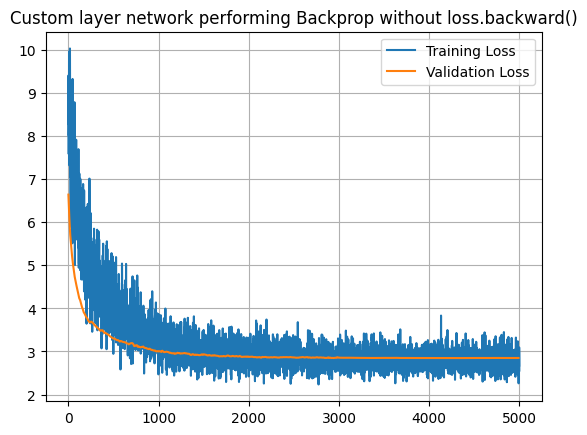

In [52]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(eval_loss_steps, eval_loss_history, label="Validation Loss")
plt.grid()
plt.legend()
plt.title("Custom layer network performing Backprop without loss.backward()")